# Example 2: non-uniqueness of linearized problem
Here we show a graph where the linearization of the inverse problem of finding
the conductivities from power measurements does not admit a unique solution.

## Graph setup
First we setup the graph, boundary conditions and graph Laplacian

In [1]:
using Plots, LinearAlgebra, Test
⊗ = kron
x =  ones(3,1)*[0 1 2];
y = [0;1;2]*ones(1,3);
D = [ -1 1 0
       0 -1 1 ]
∇ = [ D ⊗ I(3) ;  I(3) ⊗ D ]
σ1 = ones(12)  # μ = 1 => non uniqueness
σ2 = [1,2] ⊗ ones(6) # μ = 2 => uniqueness
𝐁 = [1,2,3,4,6,7,8,9];
𝐈 = [5];
n𝐈 =length(𝐈); n𝐁 = length(𝐁);
n𝐄, n𝐕 = size(∇)

f1 = [ 1, 1, 1, 1/2, 1/2, 0, 0, 0];
f2 = [ 1, 1/2, 0, 1, 0, 1, 1/2, 0];

L(σ) = ∇'*diagm(σ)*∇;

## Graph plotting

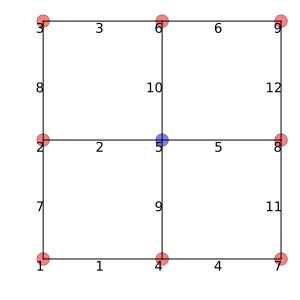

In [2]:
scatter(x[𝐈],y[𝐈], color="blue",markersize=7,markeralpha=0.5);
scatter!(x[𝐁],y[𝐁], color="red",markersize=7,markeralpha=0.5);
for i in eachindex(x)
  annotate!(x[i], y[i], text("$i",:black,:top,:right,9))
end
for (i, r) in enumerate(eachrow(∇))
  i1, i2 = findall(abs.(r) .> 0)
  plot!([x[i1], x[i2]], [y[i1], y[i2]], color="black", lw=1)
  annotate!((x[i1]+x[i2])/2, (y[i1]+y[i2])/2, text("$i", :black, :top,:right,9))
end
p=plot!(legend=:none, aspect_ratio=:equal, axis=false, grid=false,size=(300,300))

## Jacobian and injectivity test

In [3]:
R𝐈= I(n𝐕)[𝐈,:] # restriction to interior nodes
# Dirichlet problem solve
function dirsolve(σ,f)
  u = zeros(n𝐕)
  u[𝐁] = f
  u[𝐈] = -L(σ)[𝐈,𝐈]\(L(σ)[𝐈,𝐁]*f)
  return u
end
# Forward problem and Jacobian
ℒ(σ,u) = [ (L(σ)*u)[𝐈]; u[𝐁] ]
ℳ(σ,u) = σ .* (∇*u).^2
DℒDσ(σ,u) = [R𝐈*∇'*diagm(∇*u);zeros(n𝐁,n𝐄)]
DℒDu(σ,u) = [L(σ)[𝐈,:];I(n𝐕)[𝐁,:]]
DℳDσ(σ,u) = diagm((∇*u).^2)
DℳDu(σ,u) = diagm(2σ.*(∇*u))*∇

function jacobian(σ)
  u1 = dirsolve(σ,f1)
  u2 = dirsolve(σ,f2)

  𝒜 = [ DℒDσ(σ,u1) DℒDu(σ,u1)   zeros(n𝐕,n𝐕)
        DℳDσ(σ,u1) DℳDu(σ,u1)   zeros(n𝐄,n𝐕)
        DℒDσ(σ,u2) zeros(n𝐕,n𝐕) DℒDu(σ,u2)
        DℳDσ(σ,u2) zeros(n𝐄,n𝐕) DℳDu(σ,u2)
      ]
  return 𝒜
end

println("Condition number of Jacobian for σ1 is = ",cond(jacobian(σ1))," (should be ≈ 1e16)")
println("Condition number of Jacobian for σ2 is = ",cond(jacobian(σ2)))

Condition number of Jacobian for σ1 is = 3.57305372592527e16 (should be ≈ 1e16)
Condition number of Jacobian for σ2 is = 145.49670007756524


## Non-uniqueness
We give an example of a family of $\delta\sigma$ of the form $\delta\sigma =
c_1 v_1 + c_2 v_2$ which cannot recovered from power measurements in the
linearized sense. We test this by plugging  this (non-zero) $\delta\sigma,
\delta u_1, \delta u_2$ into the linearized problem and showing we get zero.

In [4]:
v1 = 4*[0,1,0,0,-1,0,0,0,0,0,0,0]
v2 = 4*[0,0,0,0,0,0,0,0,1,-1,0,0]
c1,c2 = randn(2)
δσ = c1*v1 + c2*v2
δu1 = zeros(9); δu1[𝐈] .= c1;
δu2 = zeros(9); δu2[𝐈] .= c2;

# test linearized problem equations give zero
@testset begin
  𝒜 = jacobian(σ1)
  @test norm(𝒜*[δσ;δu1;δu2]) ≈ 0
end;

Test Summary: | Pass  Total  Time
test set      |    1      1  0.0s


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*